### Import the necessary modules.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Import the dataset.

In [56]:
with zipfile.ZipFile("crashes.csv.zip") as z1:
    with z1.open("crashes.csv") as crashes:
        df_crashes = pd.read_csv(crashes)

In [57]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416872 entries, 0 to 416871
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                416872 non-null  object 
 1   RD_NO                          416813 non-null  object 
 2   CRASH_DATE_EST_I               31821 non-null   object 
 3   CRASH_DATE                     416868 non-null  object 
 4   POSTED_SPEED_LIMIT             416868 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         416868 non-null  object 
 6   DEVICE_CONDITION               416868 non-null  object 
 7   WEATHER_CONDITION              416868 non-null  object 
 8   LIGHTING_CONDITION             416868 non-null  object 
 9   FIRST_CRASH_TYPE               416867 non-null  object 
 10  TRAFFICWAY_TYPE                416867 non-null  object 
 11  LANE_CNT                       126015 non-null  float64
 12  ALIGNMENT                     

### Filter the dataset to fit the business problem.


In [58]:
df_crashes = df_crashes.loc[df_crashes["WEATHER_CONDITION"] == 'RAIN']
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36006 entries, 12 to 416854
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                36006 non-null  object 
 1   RD_NO                          35999 non-null  object 
 2   CRASH_DATE_EST_I               2270 non-null   object 
 3   CRASH_DATE                     36006 non-null  object 
 4   POSTED_SPEED_LIMIT             36006 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         36006 non-null  object 
 6   DEVICE_CONDITION               36006 non-null  object 
 7   WEATHER_CONDITION              36006 non-null  object 
 8   LIGHTING_CONDITION             36006 non-null  object 
 9   FIRST_CRASH_TYPE               36006 non-null  object 
 10  TRAFFICWAY_TYPE                36006 non-null  object 
 11  LANE_CNT                       11627 non-null  float64
 12  ALIGNMENT                      36006 non-nul

In [59]:
# Dropping null values from the target variable column
df_crashes = df_crashes.loc[df_crashes["MOST_SEVERE_INJURY"].notna()]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35894 entries, 12 to 416854
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                35894 non-null  object 
 1   RD_NO                          35887 non-null  object 
 2   CRASH_DATE_EST_I               2248 non-null   object 
 3   CRASH_DATE                     35894 non-null  object 
 4   POSTED_SPEED_LIMIT             35894 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         35894 non-null  object 
 6   DEVICE_CONDITION               35894 non-null  object 
 7   WEATHER_CONDITION              35894 non-null  object 
 8   LIGHTING_CONDITION             35894 non-null  object 
 9   FIRST_CRASH_TYPE               35894 non-null  object 
 10  TRAFFICWAY_TYPE                35894 non-null  object 
 11  LANE_CNT                       11598 non-null  float64
 12  ALIGNMENT                      35894 non-nul

## FEATURE ENGINEERING

In [60]:
# Making most severe injury column binary
injury_binary = {'NO INDICATION OF INJURY': 0, 'NONINCAPACITATING INJURY': 1, 'REPORTED, NOT EVIDENT': 1, 'INCAPACITATING INJURY': 1, 'FATAL': 1}

df_crashes["INJURY_BINARY"] = df_crashes["MOST_SEVERE_INJURY"].map(injury_binary)
df_crashes["INJURY_BINARY"].value_counts()
# Worth noting that it is very imbalanced.

0    30036
1     5858
Name: INJURY_BINARY, dtype: int64

In [61]:
col_names = ['LIGHTING_CONDITION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'MOST_SEVERE_INJURY', 'INJURY_BINARY']

df_crashes = df_crashes[col_names]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35894 entries, 12 to 416854
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LIGHTING_CONDITION  35894 non-null  object 
 1   CRASH_HOUR          35894 non-null  float64
 2   CRASH_DAY_OF_WEEK   35894 non-null  float64
 3   CRASH_MONTH         35894 non-null  float64
 4   MOST_SEVERE_INJURY  35894 non-null  object 
 5   INJURY_BINARY       35894 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB


In [62]:
df_crashes.isna().sum()

LIGHTING_CONDITION    0
CRASH_HOUR            0
CRASH_DAY_OF_WEEK     0
CRASH_MONTH           0
MOST_SEVERE_INJURY    0
INJURY_BINARY         0
dtype: int64

# EDA.

### Explore the unique values of each categorical column.

In [63]:
print("\nUnique values in the 'LIGHTING_CONDITION' column:")
print(df_crashes['LIGHTING_CONDITION'].value_counts())

print("\nUnique values in the 'MOST_SEVERE_INJURY' column:")
print(df_crashes['MOST_SEVERE_INJURY'].value_counts())


Unique values in the 'LIGHTING_CONDITION' column:
DAYLIGHT                  19727
DARKNESS, LIGHTED ROAD    10780
DARKNESS                   2455
DUSK                       1556
DAWN                        999
UNKNOWN                     377
Name: LIGHTING_CONDITION, dtype: int64

Unique values in the 'MOST_SEVERE_INJURY' column:
NO INDICATION OF INJURY     30036
NONINCAPACITATING INJURY     3280
REPORTED, NOT EVIDENT        1821
INCAPACITATING INJURY         716
FATAL                          41
Name: MOST_SEVERE_INJURY, dtype: int64


### Explore the unique values of each discrete numerical column.

In [64]:
print("Unique values in the 'CRASH_HOUR' column:")
print(df_crashes['CRASH_HOUR'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_DAY_OF_WEEK' column:")
print(df_crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_MONTH' column:")
print(df_crashes['CRASH_MONTH'].value_counts().sort_index())

Unique values in the 'CRASH_HOUR' column:
0.0      848
1.0      789
2.0      663
3.0      568
4.0      524
5.0      606
6.0      963
7.0     1655
8.0     1867
9.0     1646
10.0    1470
11.0    1588
12.0    1772
13.0    1869
14.0    1929
15.0    2379
16.0    2525
17.0    2600
18.0    2245
19.0    1858
20.0    1610
21.0    1463
22.0    1332
23.0    1125
Name: CRASH_HOUR, dtype: int64

Unique values in the 'CRASH_DAY_OF_WEEK' column:
1.0    4339
2.0    4504
3.0    4941
4.0    5552
5.0    4813
6.0    5752
7.0    5993
Name: CRASH_DAY_OF_WEEK, dtype: int64

Unique values in the 'CRASH_MONTH' column:
1.0     1788
2.0     1549
3.0     2866
4.0     4002
5.0     3870
6.0     2816
7.0     2073
8.0     2176
9.0     2546
10.0    6077
11.0    3616
12.0    2515
Name: CRASH_MONTH, dtype: int64


### Make countplots for the unique values of each categorical column.

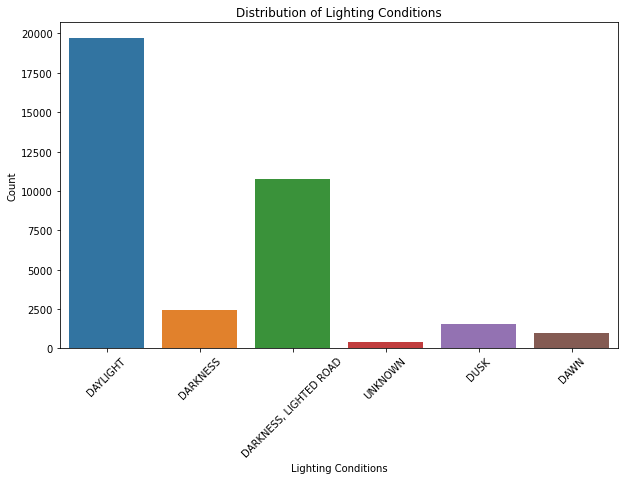

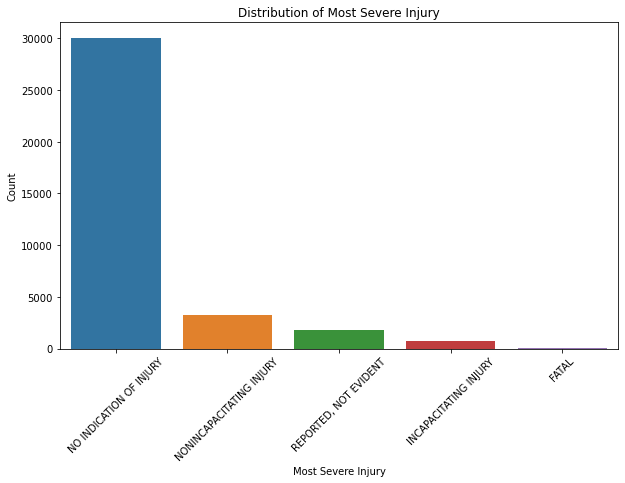

In [65]:
# Countplot for 'LIGHTING_CONDITION' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'LIGHTING_CONDITION', dodge = True)
plt.title('Distribution of Lighting Conditions')
plt.xlabel('Lighting Conditions')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'MOST_SEVERE_INJURY' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'MOST_SEVERE_INJURY', dodge = True)
plt.title('Distribution of Most Severe Injury')
plt.xlabel('Most Severe Injury')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

### Make countplots for the unique values of each discrete numerical column.

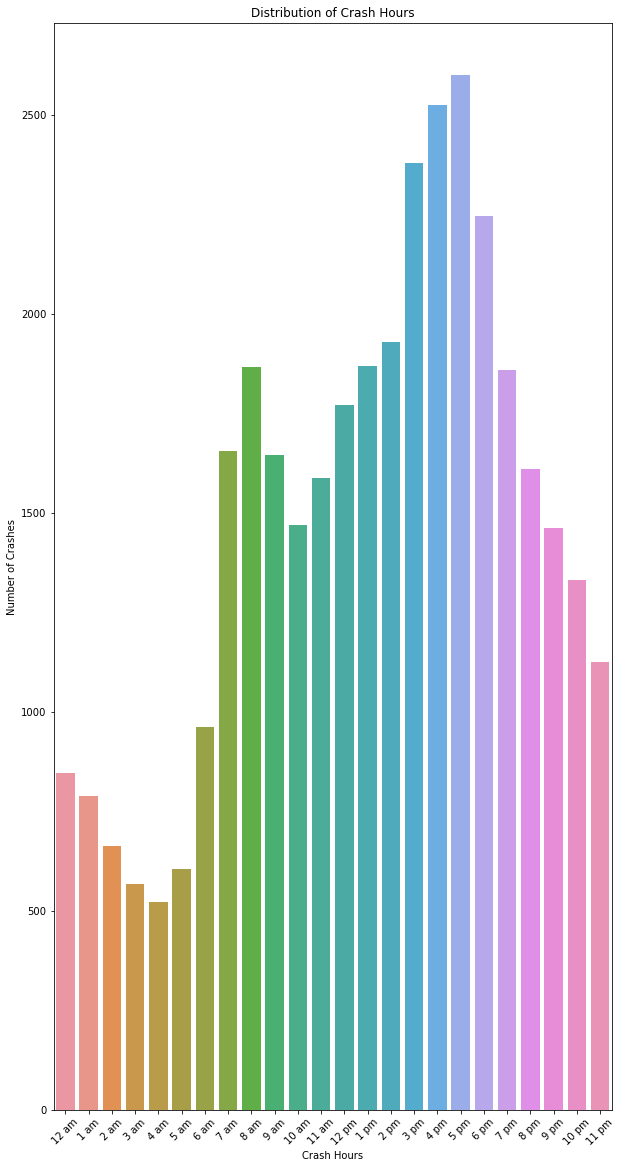

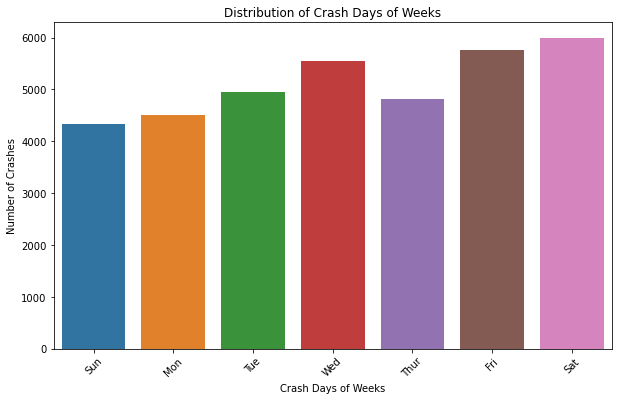

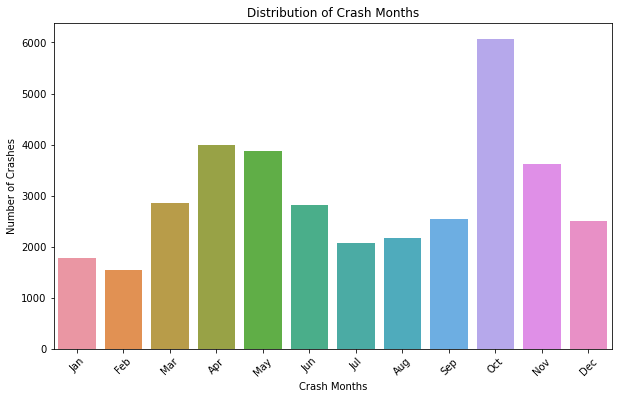

In [66]:
# Countplot for 'CRASH_HOUR'
plt.figure(figsize = (10, 20))
sns.countplot(data = df_crashes, x = 'CRASH_HOUR', dodge = True)
plt.title('Distribution of Crash Hours')
plt.xlabel('Crash Hours')
plt.ylabel('Number of Crashes')
plt.xticks(range(24), ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am',
                       '8 am', '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm',
                       '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_DAY_OF_WEEK' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'CRASH_DAY_OF_WEEK', dodge = True)
plt.title('Distribution of Crash Days of Weeks')
plt.xlabel('Crash Days of Weeks')
plt.ylabel('Number of Crashes')
plt.xticks(range(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_MONTH' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'CRASH_MONTH', dodge = True)
plt.title('Distribution of Crash Months')
plt.xlabel('Crash Months')
plt.ylabel('Number of Crashes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

### Make heatmaps of cross-tabulation between every possible 'MOST_SEVERE_INJURY' column pair.

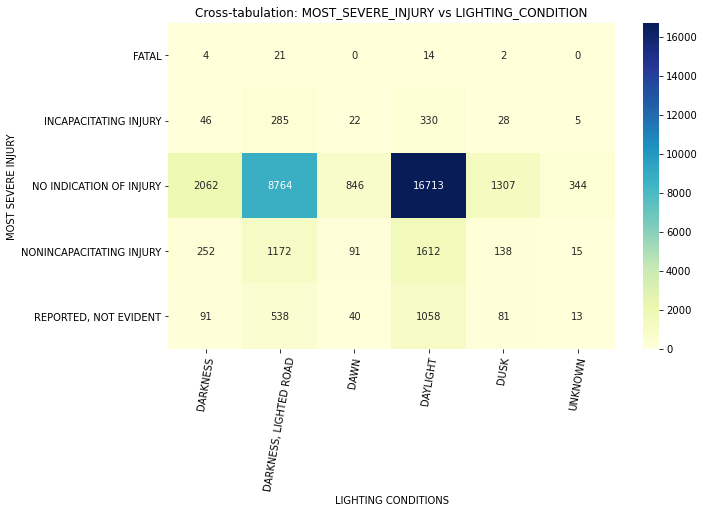

In [68]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'LIGHTING_CONDITION'
cross_tab_severe_lighting = pd.crosstab(df_crashes['MOST_SEVERE_INJURY'], df_crashes['LIGHTING_CONDITION'])
plt.figure(figsize = (10, 6))
sns.heatmap(cross_tab_severe_lighting, cmap = "YlGnBu", annot = True, fmt = 'd')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs LIGHTING_CONDITION")
plt.xlabel("LIGHTING CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

In [67]:
# groupby for EDA
grouped_crashes_binary = df_crashes.groupby(['INJURY_BINARY'])

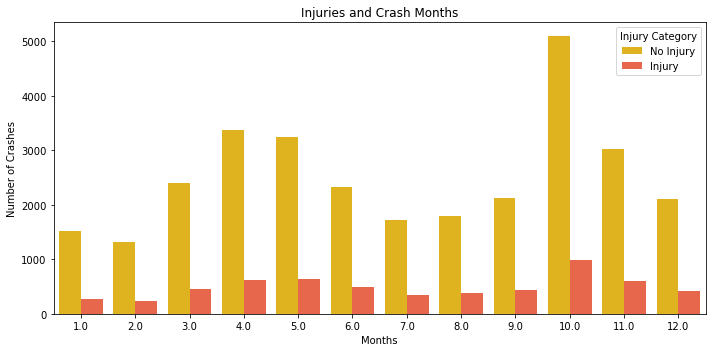

In [81]:
# A Grouped bar graph on No Injury/Injury and Crash Months

# Define a dictionary for mapping values to labels
injury_labels = {0: 'No Injury', 1: 'Injury'}

# Define custom colors for the bars
custom_colors = ['#FFC300', '#FF5733']

# Plot the countplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data = df_crashes, x = 'CRASH_MONTH', hue = 'INJURY_BINARY', hue_order = [0, 1], palette = custom_colors)

ax.set_title("Injuries and Crash Months")
ax.set_xlabel("Months")
ax.set_ylabel("Number of Crashes")

plt.legend(title = 'Injury Category', labels = injury_labels.values(), loc = 'upper right')
plt.tight_layout()

# Show the plot
plt.show()

# I would have guessed more crashes during the winter months
# But there seems to be no dramatic differences between months

### TRAIN-TEST SPLIT

In [82]:
from sklearn.model_selection import train_test_split

# Split the features and target variable
X = df_crashes.drop(['INJURY_BINARY','MOST_SEVERE_INJURY'], axis = 1)  # Features
y = df_crashes.INJURY_BINARY  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# PREPROCESSING

### PERFORM ONE-HOT ENCODING FOR ANY CATEGORICAL COLUMN(S).

In [83]:
from sklearn.preprocessing import OneHotEncoder

# Specify the categorical columns to encode (assuming they are categorical columns)
categorical_cols = ['LIGHTING_CONDITION']

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore')

# Fit the encoder on the training data
encoder.fit(X_train[categorical_cols])

# Transform the categorical columns in both the training and testing sets
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert the encoded sparse matrix to a dense array
X_train_encoded = X_train_encoded.toarray()
X_test_encoded = X_test_encoded.toarray()

# Concatenate the encoded features with the remaining numerical features
X_train_encoded = np.concatenate((X_train_encoded, X_train.drop(categorical_cols, axis = 1)), axis = 1)
X_test_encoded = np.concatenate((X_test_encoded, X_test.drop(categorical_cols, axis = 1)), axis = 1)

### PERFORM SMOTE TO ADDRESS CLASS IMBALANCE.

In [85]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train) # <-----------------------------

### APPLY A DUMMY CLASSIFIER AS THE BASELINE MODEL.

In [86]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a baseline model
dummy_model = DummyClassifier(strategy = 'most_frequent')

# Train the model on the resampled training data
dummy_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred = dummy_model.predict(X_test_encoded)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      9011
           1       0.00      0.00      0.00      1758

    accuracy                           0.84     10769
   macro avg       0.42      0.50      0.46     10769
weighted avg       0.70      0.84      0.76     10769



c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


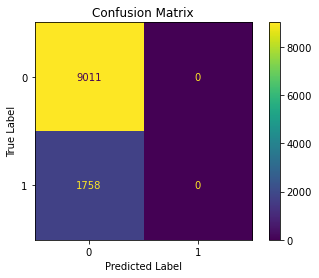

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

# Display the confusion matrix
disp.plot()

# Add a title and axis labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

### APPLY A DECISION TREE MODEL.

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Create an instance of the DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state = 42)

# Train the model 
tree_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred_tree = tree_model.predict(X_test_encoded)

# Evaluate the model's performance using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      9011
           1       0.17      0.22      0.19      1758

    accuracy                           0.70     10769
   macro avg       0.51      0.51      0.51     10769
weighted avg       0.73      0.70      0.71     10769



### BINARY LOGISTIC REGRESSION BABY

In [95]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the logistic regression model
logreg_model = LogisticRegression()

# Train the logistic regression model
logreg_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred_logreg = logreg_model.predict(X_test_encoded)

# Evaluate the logistic regression 
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      9011
           1       0.19      0.35      0.24      1758

    accuracy                           0.64     10769
   macro avg       0.52      0.52      0.50     10769
weighted avg       0.74      0.64      0.68     10769



#### Examine coefficients for the logistic regression model. 

In [98]:
encoder = OneHotEncoder()  
encoder.fit(X_train) 

# Obtain the feature names for the encoded features
feature_names = encoder.get_feature_names_out() 

# Access the coefficients
coefficients = logreg_model.coef_

# Print feature names with their corresponding coefficients
for feature, coef in zip(feature_names, coefficients[0]):
    print(f"{feature}: {coef}")


LIGHTING_CONDITION_DARKNESS: 0.13450065052172422
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: 0.5235114650188314
LIGHTING_CONDITION_DAWN: -0.15925610835224246
LIGHTING_CONDITION_DAYLIGHT: 0.2591381012637218
LIGHTING_CONDITION_DUSK: 0.18278001254156123
LIGHTING_CONDITION_UNKNOWN: -1.2494307201423749
CRASH_HOUR_0.0: -0.0027673933727354744
CRASH_HOUR_1.0: -0.0011359473928636418
CRASH_HOUR_2.0: 0.005784173531396848


### TUNE THE LOGISTIC REGRESSION HYPERPARAMETERS USING GRID SEARCH CROSS-VALIDATION. (NOT WORKING)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Create logistic regression model
logreg_model = LogisticRegression()

# Define the hyperparameter search space
param_grid = {
    'C': uniform(0.01, 10),  # Range of values for regularization parameter C
    'penalty': ['l1', 'l2'],  # Regularization types to consider
    'solver': ['liblinear', 'saga']  # Solver algorithms to consider
}

# Create the randomized search object
random_search = RandomizedSearchCV(
    estimator = logreg_model,
    param_distributions=param_grid,
    n_iter = 10,  # Number of iterations to sample from the search space
    cv = 5,  # Number of cross-validation folds
    scoring = 'recall',  # Evaluation metric to optimize
    random_state = 42
)

# Perform the randomized search
random_search.fit(X_train, y_train) 

# Access the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on the validation or test set
y_pred = best_model.predict(X_test)  
classification_report = classification_report(y_test, y_pred)

# Print the best hyperparameters and classification report
print("Best Hyperparameters:", best_params)
print("Classification Report:")
print(classification_report)


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1207, in fit
    X, y = self._validate_data(
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\numpy\core\_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py", line 1781, in __array__
    return np.asarray(self._values, dtype=dtype)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\numpy\core\_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
ValueError: could not convert string to float: 'DAYLIGHT'

--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1207, in fit
    X, y = self._validate_data(
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\numpy\core\_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py", line 1781, in __array__
    return np.asarray(self._values, dtype=dtype)
  File "c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\numpy\core\_asarray.py", line 85, in asarray
    return array(a, dtype, copy=False, order=order)
ValueError: could not convert string to float: 'DARKNESS, LIGHTED ROAD'
